# Analysis of SEMITONES enriched genomic regions - Luecken et al.

In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from SEMITONES.enrichment_scoring import sig_interval
from SEMITONES.support_funcs import sig_dictionary
from SEMITONES.support_funcs import sig_bool

In [4]:
adata = ad.read_h5ad("../processed/Luecken_multiome_BMMC-r_adata.h5ad")

In [5]:
ATAC_es = pd.read_hdf('../processed/Luecken_ATAC_escore.h5','escores')
ATAC_ps = pd.read_hdf('../processed/Luecken_ATAC_pscore.h5','pscores')

In [6]:
ATAC_interval = sig_interval(ATAC_ps, n_sds=10)
ATAC_sigdict = sig_dictionary(ATAC_es, ATAC_interval)
ATAC_sigdict_acc = sig_dictionary(ATAC_es, ATAC_interval, sign='positive')
ATAC_sigdict_inacc = sig_dictionary(ATAC_es, ATAC_interval, sign='negative')

In [8]:
# load Homer annotation
ann = pd.read_csv('../processed/Luecken_ATAC_ann_hg38.txt', sep='\t', index_col=0)
ann.sort_index(inplace=True)
ann.reset_index(drop=True, inplace=True)

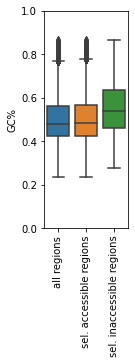

In [9]:
# GC content of selectively accessible and inaccessible regions
gc_df_all = pd.DataFrame({'GC%':ann.loc[:,'GC%']})
gc_df_all['group'] = 'all regions'

acc_feature = []
inacc_feature = []
for rcell in ATAC_sigdict_acc:
    acc_feature.extend(ATAC_sigdict_acc[rcell])
    inacc_feature.extend(ATAC_sigdict_inacc[rcell])
acc_feature = list(set(acc_feature))
inacc_feature = list(set(inacc_feature))

gc_df_acc = pd.DataFrame({'GC%':ann.iloc[acc_feature,-1]})
gc_df_acc['group'] = 'sel. accessible regions'

gc_df_inacc = pd.DataFrame({'GC%':ann.iloc[inacc_feature,-1]})
gc_df_inacc['group'] = 'sel. inaccessible regions'

gc_region_df = pd.concat([gc_df_all, gc_df_acc, gc_df_inacc]).dropna()

fig, ax = plt.subplots(figsize=(1.5,4))
sns.boxplot(data=gc_region_df, x='group', y='GC%', ax=ax)
ax.set(xlabel='')
ax.set_ylim([0,1])
plt.xticks(rotation=90)
plt.show()

In [10]:
prom_set = set(np.where(ann['Annotation'].str.contains('promoter'))[0])

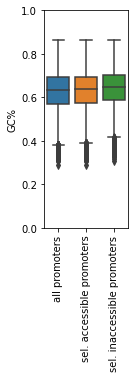

In [11]:
# GC content of selectively accessible and inaccessible promoters
gc_df_all = pd.DataFrame({'GC%':ann.iloc[list(prom_set),-1]})
gc_df_all['group'] = 'all promoters'

acc_feature = []
inacc_feature = []
for rcell in ATAC_sigdict_acc:
    acc_feature.extend(ATAC_sigdict_acc[rcell])
    inacc_feature.extend(ATAC_sigdict_inacc[rcell])
acc_feature = list(set(acc_feature).intersection(prom_set))
inacc_feature = list(set(inacc_feature).intersection(prom_set))

gc_df_acc = pd.DataFrame({'GC%':ann.iloc[acc_feature,-1]})
gc_df_acc['group'] = 'sel. accessible promoters'

gc_df_inacc = pd.DataFrame({'GC%':ann.iloc[inacc_feature,-1]})
gc_df_inacc['group'] = 'sel. inaccessible promoters'

gc_region_df = pd.concat([gc_df_all, gc_df_acc, gc_df_inacc]).dropna()

fig, ax = plt.subplots(figsize=(1.5,4))
sns.boxplot(data=gc_region_df, x='group', y='GC%', ax=ax)
ax.set(xlabel='')
ax.set_ylim([0,1])
plt.xticks(rotation=90)
plt.show()

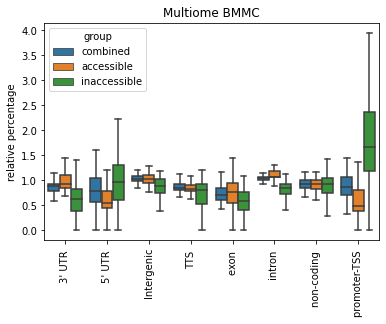

In [12]:
# the change in percentage of different genomic annotations in selectively accessible and inaccessible regions
all_series = ann['Annotation'].str.split('(', expand=True)[0]

def rel_sig_df(sigdict, all_series):    
    concat_data = []
    for rcell in sigdict:
        #rcell = 21887
        tmp_series = all_series[sigdict[rcell]].value_counts(normalize=True)
        tmp_series.name = rcell

        concat_data.append(tmp_series)
    df = pd.concat(concat_data,axis=1)
    df = df.fillna(0)

    rel_df = df.div(all_series.value_counts(normalize=True),axis=0)
    rel_df.sort_index(inplace=True)
    return rel_df

rel_df_acc = rel_sig_df(ATAC_sigdict_acc, all_series)
rel_df_inacc = rel_sig_df(ATAC_sigdict_inacc, all_series)
rel_df_comb = rel_sig_df(ATAC_sigdict, all_series)


comb=rel_df_comb.reset_index().melt(id_vars='index')
comb['group']='combined'
acc=rel_df_acc.reset_index().melt(id_vars='index')
acc['group']='accessible'
inacc=rel_df_inacc.reset_index().melt(id_vars='index')
inacc['group']='inaccessible'
boxdf=pd.concat([comb,acc,inacc], axis=0)

fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(x=boxdf['index'], y=boxdf['value'], hue=boxdf['group'], ax=ax,
           showfliers=False)
ax.set(xlabel='', ylabel='relative percentage', title='Multiome BMMC')
plt.xticks(rotation=90)
plt.show()